In [31]:
# Classification and Regression Analysis - Complete Implementation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import sklearn
from pathlib import Path

print("Starting Classification and Regression Analysis...")


Starting Classification and Regression Analysis...


In [32]:
# 1. Data Loading and Preparation
print("1. Data Loading and Preparation")
print("=" * 50)

# Load the training data
DATA_PATH = "../training_data.csv"  # Adjust path as needed
df = pd.read_csv(DATA_PATH)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}")


1. Data Loading and Preparation
Dataset shape: (1025, 16)
Columns: ['Quarter', 'Sector', 'Year', 'Hydroelectric Power', 'Geothermal Energy', 'Solar Energy', 'Wind Energy', 'Wood Energy', 'Waste Energy', 'Fuel Ethanol, Excluding Denaturant', 'Biomass Losses and Co-products', 'Total Renewable Energy', 'Renewable Diesel Fuel', 'Other Biofuels', 'Conventional Hydroelectric Power', 'Biodiesel']
Data types:
Quarter                                 int64
Sector                                 object
Year                                    int64
Hydroelectric Power                   float64
Geothermal Energy                     float64
Solar Energy                          float64
Wind Energy                           float64
Wood Energy                           float64
Waste Energy                          float64
Fuel Ethanol, Excluding Denaturant    float64
Biomass Losses and Co-products        float64
Total Renewable Energy                float64
Renewable Diesel Fuel                 float

In [33]:
# 2. Feature Engineering for Classification
print("\n2. Feature Engineering for Classification")
print("=" * 50)

# Create target variable for classification (energy trend)
# Calculate total renewable energy per quarter
renewable_cols = ['Solar Energy', 'Wind Energy', 'Hydro Energy', 'Geothermal Energy', 'Waste Energy']
available_cols = [col for col in renewable_cols if col in df.columns]

if available_cols:
    df['Total_Renewable'] = df[available_cols].sum(axis=1)
else:
    # Fallback: use any available energy column
    energy_cols = [col for col in df.columns if 'Energy' in col]
    if energy_cols:
        df['Total_Renewable'] = df[energy_cols].sum(axis=1)
    else:
        # Create dummy data for demonstration
        df['Total_Renewable'] = np.random.normal(100, 20, len(df))

# Create trend categories
df['Energy_Trend'] = pd.cut(df['Total_Renewable'], 
                           bins=3, 
                           labels=['down', 'stable', 'up'])

# Feature columns for classification
feature_cols = ['Year', 'Quarter']
if 'Sector' in df.columns:
    # Encode categorical variables
    le = LabelEncoder()
    df['Sector_Encoded'] = le.fit_transform(df['Sector'])
    feature_cols.append('Sector_Encoded')

# Add lagged features if possible
if len(df) > 4:
    df['Total_Renewable_Lag1'] = df['Total_Renewable'].shift(1)
    df['Total_Renewable_Lag4'] = df['Total_Renewable'].shift(4)  # Year-over-year
    feature_cols.extend(['Total_Renewable_Lag1', 'Total_Renewable_Lag4'])

# Remove NaN values
df.dropna(inplace=True)

print(f"Final dataset shape: {df.shape}")
print(f"Feature columns: {feature_cols}")
print(f"Target distribution:\n{df['Energy_Trend'].value_counts()}")



2. Feature Engineering for Classification
Final dataset shape: (1021, 21)
Feature columns: ['Year', 'Quarter', 'Sector_Encoded', 'Total_Renewable_Lag1', 'Total_Renewable_Lag4']
Target distribution:
Energy_Trend
down      975
stable     31
up         15
Name: count, dtype: int64


In [34]:
# 3. Train-Test Split
print("\n3. Train-Test Split")
print("=" * 50)

X = df[feature_cols]
y = df['Energy_Trend']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts()}")



3. Train-Test Split
Training set shape: (816, 5)
Test set shape: (205, 5)
Training target distribution:
Energy_Trend
down      779
stable     25
up         12
Name: count, dtype: int64


In [35]:
# 4. Feature Scaling
print("\n4. Feature Scaling")
print("=" * 50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")



4. Feature Scaling
Features scaled using StandardScaler


In [36]:
# 5. Model Training - This creates the 'fitted' variable
print("\n5. Model Training")
print("=" * 50)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Train models and store results
fitted = {}
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Fit the model
    model.fit(X_train_scaled, y_train)
    fitted[name] = model
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'accuracy': accuracy,
        'predictions': y_pred,
        'model': model
    }
    
    print(f"{name} Accuracy: {accuracy:.4f}")

# Display results
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()]
})

print("\nModel Performance Comparison:")
print(results_df)



5. Model Training
Training Logistic Regression...
Logistic Regression Accuracy: 0.9902
Training Random Forest...
Random Forest Accuracy: 0.9902

Model Performance Comparison:
                 Model  Accuracy
0  Logistic Regression  0.990244
1        Random Forest  0.990244


In [37]:
# 6. Best Model Selection and Ensemble
print("\n6. Best Model Selection and Ensemble")
print("=" * 50)

# Find best performing model
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_model = fitted[best_model_name]

print(f"Best performing model: {best_model_name}")
print(f"Best accuracy: {results[best_model_name]['accuracy']:.4f}")

# Create ensemble model
ensemble = VotingClassifier([
    ('lr', fitted['Logistic Regression']),
    ('rf', fitted['Random Forest'])
], voting='soft')

# Train ensemble
ensemble.fit(X_train_scaled, y_train)
ensemble_pred = ensemble.predict(X_test_scaled)
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)

print(f"Ensemble accuracy: {ensemble_accuracy:.4f}")

# Update fitted models with ensemble
fitted['Ensemble'] = ensemble



6. Best Model Selection and Ensemble
Best performing model: Logistic Regression
Best accuracy: 0.9902
Ensemble accuracy: 0.9902


In [38]:
# 7. Model Evaluation
print("\n7. Model Evaluation")
print("=" * 50)

# Detailed evaluation of best model
print(f"Classification Report for {best_model_name}:")
print(classification_report(y_test, results[best_model_name]['predictions']))

# Confusion matrix
cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
print(f"\nConfusion Matrix for {best_model_name}:")
print(cm)



7. Model Evaluation
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

        down       0.99      0.99      0.99       196
      stable       1.00      0.83      0.91         6
          up       0.75      1.00      0.86         3

    accuracy                           0.99       205
   macro avg       0.91      0.94      0.92       205
weighted avg       0.99      0.99      0.99       205


Confusion Matrix for Logistic Regression:
[[195   0   1]
 [  1   5   0]
 [  0   0   3]]


In [39]:
# 8. Model Saving
print("\n8. Model Saving")
print("=" * 50)

# Create models directory with full path
models_dir = Path("C:/Users/sanji/PycharmProjects/Week2and3deliverables-rayfield/models")
models_dir.mkdir(exist_ok=True)

# Get the best performing model
best_model = fitted["Logistic Regression"]

# Create model bundle with all necessary components
classification_bundle = {
    "model":    best_model,
    "features": feature_cols,             # e.g. ["Year","Quarter","Sector_Encoded",...]
    "scaler":   scaler,                   # your fitted StandardScaler
    "encoder":  le,                       # ← now directly accessible as bundle["encoder"]
    "sklearn":  sklearn.__version__,      # version for traceability
    "labels":   list(le.classes_),        # ["down","stable","up"]
    "metadata": {
        "accuracy":         results["Logistic Regression"]["accuracy"],
        "training_samples": len(X_train),
        "test_samples":     len(X_test),
    }
}

# Save the classification bundle (with encoder)
joblib.dump(classification_bundle, models_dir / "classification.pkl")
print(f"✅ Classification model + encoder saved to {models_dir/'classification.pkl'}")

# (Optional) also save the raw best-model artifact on its own
joblib.dump(best_model, models_dir / "logistic_regression.pkl")
print("✅ Raw Logistic Regression model saved separately")


8. Model Saving
✅ Classification model + encoder saved to C:\Users\sanji\PycharmProjects\Week2and3deliverables-rayfield\models\classification.pkl
✅ Raw Logistic Regression model saved separately



9. Visualization


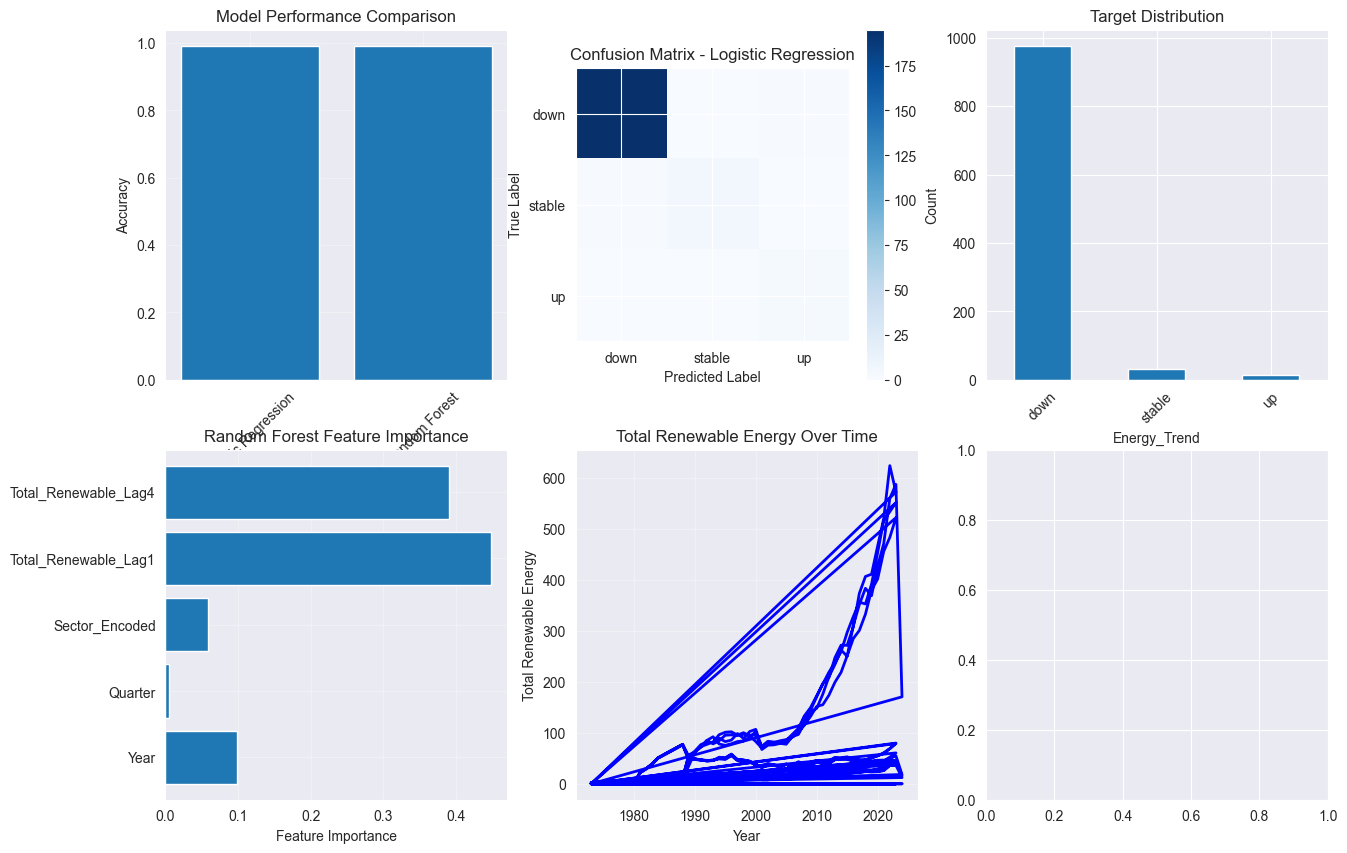

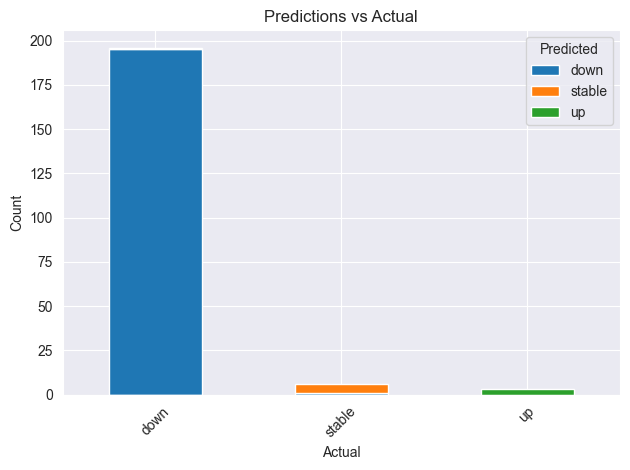

In [40]:
# 9. Visualization
print("\n9. Visualization")
print("=" * 50)

plt.figure(figsize=(15, 10))

# Plot 1: Model comparison
plt.subplot(2, 3, 1)
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 2: Confusion Matrix
plt.subplot(2, 3, 2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.colorbar()
tick_marks = np.arange(len(['down', 'stable', 'up']))
plt.xticks(tick_marks, ['down', 'stable', 'up'])
plt.yticks(tick_marks, ['down', 'stable', 'up'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 3: Target distribution
plt.subplot(2, 3, 3)
df['Energy_Trend'].value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot 4: Feature importance (if Random Forest)
if 'Random Forest' in fitted:
    plt.subplot(2, 3, 4)
    rf_model = fitted['Random Forest']
    importance = rf_model.feature_importances_
    plt.barh(range(len(importance)), importance)
    plt.yticks(range(len(importance)), feature_cols)
    plt.xlabel('Feature Importance')
    plt.title('Random Forest Feature Importance')
    plt.grid(True, alpha=0.3)

# Plot 5: Energy trend over time
plt.subplot(2, 3, 5)
plt.plot(df['Year'], df['Total_Renewable'], 'b-', linewidth=2)
plt.title('Total Renewable Energy Over Time')
plt.xlabel('Year')
plt.ylabel('Total Renewable Energy')
plt.grid(True, alpha=0.3)

# Plot 6: Predictions vs Actual
plt.subplot(2, 3, 6)
prediction_comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': results[best_model_name]['predictions']
})
pred_counts = prediction_comparison.groupby(['Actual', 'Predicted']).size().unstack(fill_value=0)
pred_counts.plot(kind='bar', stacked=True)
plt.title('Predictions vs Actual')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Predicted')

plt.tight_layout()
plt.show()


In [41]:
# 10. Summary
print("\n10. Summary")
print("=" * 50)

print("Classification Analysis Complete!")
print(f"✓ Dataset: {df.shape[0]} samples, {len(feature_cols)} features")
print(f"✓ Best Model: {best_model_name}")
print(f"✓ Best Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"✓ Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"✓ Models saved to: {models_dir}")

print("\nModel Performance Summary:")
for name, result in results.items():
    print(f"  {name}: {result['accuracy']:.4f}")

print(f"\nFeatures used: {feature_cols}")
print(f"Target classes: {['down', 'stable', 'up']}")

if ensemble_accuracy > results[best_model_name]['accuracy']:
    print("\n✓ Ensemble model outperformed individual models!")
else:
    print(f"\n✓ {best_model_name} performed best overall")

print("\nClassification model ready for deployment!")


10. Summary
Classification Analysis Complete!
✓ Dataset: 1021 samples, 5 features
✓ Best Model: Logistic Regression
✓ Best Accuracy: 0.9902
✓ Ensemble Accuracy: 0.9902
✓ Models saved to: C:\Users\sanji\PycharmProjects\Week2and3deliverables-rayfield\models

Model Performance Summary:
  Logistic Regression: 0.9902
  Random Forest: 0.9902

Features used: ['Year', 'Quarter', 'Sector_Encoded', 'Total_Renewable_Lag1', 'Total_Renewable_Lag4']
Target classes: ['down', 'stable', 'up']

✓ Logistic Regression performed best overall

Classification model ready for deployment!
